In [1]:
import pandas as pd
from pathlib import Path
import inspect 
import numpy as np
import datetime
import os
import json
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from dotmap import DotMap
import torch
import torch.nn.init as init
import torch.nn as nn
import pickle
import torch.autograd as autograd
from torchviz import make_dot
from torchsummary import summary
from termcolor import colored
import seaborn as sns
sns.set()


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics.pairwise import rbf_kernel
from scipy.stats import wasserstein_distance, entropy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
reserved = int(torch.cuda.max_memory_reserved() / 1000 / 1000)
gpu_available = torch.cuda.is_available()

print(colored(f"GPU available! {torch.cuda.get_device_name()}. Memory reserved: {reserved}MB", "green") if gpu_available else colored("No GPU. Running on CPU", "red"))

GPU available! NVIDIA GeForce RTX 3060. Memory reserved: 0MB


In [4]:
timestamp = datetime.datetime.now()
timestamp = f"{timestamp.year}-{timestamp.month}-{timestamp.day}_{timestamp.hour}-{timestamp.minute}-{timestamp.second}-{timestamp.microsecond}"

save_dir = Path(timestamp + "_Graphs")
if save_dir.exists():
    raise f"Directory exists: {save_dir.as_posix()}"
os.makedirs(save_dir.as_posix())

## Model Building and Training

### Data

In [5]:
data = pd.read_parquet("../data_manipulation/final_night_data.parquet")

In [6]:
def set_season_tag(df, isnorth = True):
    if isnorth:
        df["season"] = (df['DateTime'].dt.month%12 + 3) // 3 # print(seasons)
    else:
        df["season"] = ((df['DateTime'].dt.month + 6)%12 + 3)//3
    return df, "season"

def extract_time_features(df):
    """
    Extract features from the timestamp for model training.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    
    Returns:
    pd.DataFrame: DataFrame with extracted features, list: features added to dataframe
    """
    df = df.copy()
    df['hour'] = df['DateTime'].dt.hour
    df['dayofweek'] = df['DateTime'].dt.dayofweek
    df['month'] = df['DateTime'].dt.month
    df['dayofyear'] = df['DateTime'].dt.dayofyear
    return df, ["hour", "dayofweek", "month", "dayofyear"]
    
def split_data(df, test_size=0.2):
    """
    Split data into training and test sets.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    test_size (float): Proportion of the data to include in the test split.
    
    Returns:
    tuple: Training and test DataFrames.
    """
    train_data, test_data = train_test_split(df, test_size=test_size, shuffle=False)
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

In [7]:
drivers = np.array(['Ta', 'H', 'Tau', 'LE_strg', 'RH', 'VPD', 'Rg', 'Ustar', 'Tsoil1', 'Tsoil2'])

In [8]:
data, season_feat = set_season_tag(data)
data, time_feat = extract_time_features(data)

In [9]:
data = data[data["dNEE"].notna()].reset_index(drop=True)

In [10]:
data.shape

(21535, 76)

In [11]:
drivers = np.concatenate([drivers, [season_feat], time_feat])

In [12]:
columns_to_check_na = np.concatenate([drivers, ["NEE", "dTa"]])

idx = (np.sum(data[columns_to_check_na].notna(), axis=1) == columns_to_check_na.shape[0])
data = data.loc[idx].reset_index(drop=True)

### Training Data 

In [13]:
train_data, test_data = split_data(data)

In [14]:
X_train = train_data[drivers]
NEE_train = train_data["NEE_next"]
dT_train = train_data["dTa"]
dNEE_train = train_data["dNEE"]
bNEE_train = train_data["NEE"]
K_train = train_data[["E0", "rb"]]

X_test = test_data[drivers]
NEE_test = test_data["NEE_next"]
dT_test = test_data["dTa"]
dNEE_test = test_data["dNEE"]
bNEE_test = test_data["NEE"]
K_test = test_data[["E0", "rb"]]


In [15]:
normalizer = StandardScaler()

X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

In [16]:
with open(save_dir.joinpath("normalizer.pickle"), "wb") as fp:
    pickle.dump(normalizer, fp)

### Model Building

In [18]:
def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        # Apply He initialization
        init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
        init.zeros_(layer.bias)

In [78]:
class PIAE_SDE_day(nn.Module):
    def __init__(self, input_dim, latent_dim, encoder_dims, decoder_dims, activation=nn.Tanh):
        super(PIAE_SDE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.activation = activation
        self.Tref = torch.tensor(10).to("cuda")
        self.T0 = torch.tensor(46.02).to("cuda")
        self.encoder_dims = encoder_dims
        self.decoder_dims = decoder_dims
        self.k_min = torch.tensor([50, 0.0001, 0.0001, 0.0001]).view((-1, 4)).to("cuda")
        self.k_max = torch.tensor([400, 20, 1, 300]).view((-1, 4)).to("cuda")

        # Encoder network
        modules = self.append_linear_modules(self.input_dim, self.encoder_dims)
        print(modules)
        self.encoder = nn.Sequential(*modules)

         # Decoder network for NEE (u)
        modules = self.append_linear_modules(self.latent_dim, self.decoder_dims) 
        modules.append(nn.Linear(self.decoder_dims[-1], 1))
        self.nee_decoder = nn.Sequential(*modules)
        
        # Decoder network for dT/dt (f)
        modules = self.append_linear_modules(self.latent_dim, self.decoder_dims) 
        modules.append(nn.Linear(self.decoder_dims[-1], 1))
        self.temp_derivative_decoder = nn.Sequential(*modules)

        # Decoder network for dRg/dt (f)
        modules = self.append_linear_modules(self.latent_dim, self.decoder_dims) 
        modules.append(nn.Linear(self.decoder_dims[-1], 1))
        self.radiation_derivative_decoder = nn.Sequential(*modules)
        
        # Decoder network for E0 and rb and alpha and beta
        modules = self.append_linear_modules(self.latent_dim, self.decoder_dims) 
        modules.append(nn.Linear(self.decoder_dims[-1], 4))
        self.k_decoder = nn.Sequential(*modules)
    
    def append_linear_modules(self, in_dim, dims):
        modules = []
        for i, dim in enumerate(dims):
            modules.append(nn.Linear(in_dim, dim))
            if i != len(dims) - 1:
                modules.append(self.activation())
            in_dim = dim
        return modules
        
    def forward(self, x):
        z = self.encoder(x)
        
        nee = self.nee_decoder(z)
        dT_dt = self.temp_derivative_decoder(z)
        dRg_dt = self.radiation_derivative_decoder(z)
        k = self.k_decoder(z)
        # print("k", torch.mean(k, 0))
        k = self.k_min + (self.k_max - self.k_min) * torch.sigmoid(k)
        # print("k", torch.mean(k, 0))
        
        f, residual = self.physics_residual(nee, x, k, x[:, 0].view((-1, 1)), x[:, 1].view((-1, 1)), dT_dt, dRg_dt)
        return nee, dT_dt, dRg_dt, k, f, z, residual

    def physics_residual(self, nee, x, k, T, Rg, dT_dt, dRg_dt):
        E0 = k[:, 0].view((-1, 1))
        rb = k[:, 1].view((-1, 1))
        alpha = k[:, 2].view((-1, 1))
        beta = k[:, 3].view((-1, 1))
        
        # Compute dReco/dT using predicted E0 and rb
        exp_term = torch.exp(E0 * (1.0 / (self.Tref - self.T0) - 1.0 / (T - self.T0))).view((-1, 1))
        dReco_dT = rb * (E0 / (T - self.T0)**2) * exp_term

        # print("dReco_dT", torch.mean(dReco_dT))
        
        # Compute dGpp/dRg using predicted alpha and beta
        # print("Rg", torch.mean(Rg))
        dGpp_dRg = (alpha * beta**2) / (alpha*Rg + beta)**2

        # print("dGpp_dRg", torch.mean(dGpp_dRg))

        # Physics-based residual f = dNEE/dt - (dNEE/dT) * (dT/dt)
        #f_residual = autograd.grad(nee, x, grad_outputs=torch.ones_like(nee), create_graph=True)[:, 0]
        residual = torch.zeros_like(nee) #f_residual - dNEE_dT * dT_dt
 
        f = dReco_dT * dT_dt - dGpp_dRg * dRg_dt

        # print("f", torch.mean(f))
        return f, residual
        # Incorporate boundary condition (NEE_t should be close to NEE_{t-1})

class PIAE_SDE_night(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim, activation=nn.Tanh):
        super(PIVAE_SDE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.activation = activation
        self.Tref = torch.tensor(10).to("cuda")
        self.T0 = torch.tensor(46.02).to("cuda")
        
        # Encoder network
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            activation(),
            nn.Linear(hidden_dim, hidden_dim),
            activation(),
            nn.Linear(hidden_dim, latent_dim)
        )
        
        # Decoder network for NEE (u)
        self.nee_decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            activation(),
            nn.Linear(hidden_dim, hidden_dim),
            activation(),
            nn.Linear(hidden_dim, 1)  # Output NEE (u)
        )
        
        # Decoder network for dT/dt (f)
        self.temp_derivative_decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            activation(),
            nn.Linear(hidden_dim, hidden_dim),
            activation(),
            nn.Linear(hidden_dim, 1)  # Output dT/dt
        )
        
        # Decoder network for E0 and rb (k)
        self.k_decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            activation(),
            nn.Linear(hidden_dim, hidden_dim),
            activation(),
            nn.Linear(hidden_dim, 2)  # Output E0 and rb
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x, b, k):
        input_ = torch.cat((x, b.view(x.shape[0], 1), k), dim=1).to("cuda")
        z = self.encoder(input_)
        nee = self.nee_decoder(z)
        dT_dt = self.temp_derivative_decoder(z)
        k = self.k_decoder(z)
        f, residual = self.physics_residual(nee, x, k, x[:, 0].view((-1, 1)), dT_dt)
        
        return nee, dT_dt, k, f, z, residual

    def physics_residual(self, nee, x, k, T, dT_dt):
        E0 = k[:, 0].view((-1, 1))
        rb = k[:, 1].view((-1, 1))
        
        # Compute dNEE/dT using predicted E0 and rb
        exp_term = torch.exp(E0 * (1.0 / (self.Tref - self.T0) - 1.0 / (T - self.T0))).view((-1, 1))
        dNEE_dT = rb * (E0 / (T - self.T0)**2) * exp_term

        # Physics-based residual f = dNEE/dt - (dNEE/dT) * (dT/dt)
        #f_residual = autograd.grad(nee, x, grad_outputs=torch.ones_like(nee), create_graph=True)[:, 0]
        residual = torch.zeros_like(nee) #f_residual - dNEE_dT * dT_dt
 
        f = dNEE_dT * dT_dt
        
        return f, residual
        # Incorporate boundary condition (NEE_t should be close to NEE_{t-1})

class AE_night(nn.Module):
    def __init__(self, input_dim, latent_dim, encoder_dims, decoder_dims, activation=nn.Tanh):
        super(AE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.activation = activation
        self.Tref = torch.tensor(10).to("cuda")
        self.T0 = torch.tensor(46.02).to("cuda")
        self.encoder_dims = encoder_dims
        self.decoder_dims = decoder_dims
        
        # Encoder network
        modules = self.append_linear_modules(self.input_dim, self.encoder_dims)
        print(modules)
        self.encoder = nn.Sequential(*modules)

               # Decoder network for NEE (u)
        modules = self.append_linear_modules(self.latent_dim, self.decoder_dims) 
        modules.append(nn.Linear(self.decoder_dims[-1], 1))
        self.nee_decoder = nn.Sequential(*modules)

        # Decoder network for E0 and rb
        modules = self.append_linear_modules(self.latent_dim, self.decoder_dims) 
        modules.append(nn.Linear(self.decoder_dims[-1], 2))
        self.k_decoder = nn.Sequential(*modules)
        

    def append_linear_modules(self, in_dim, dims):
        modules = []
        for i, dim in enumerate(dims):
            modules.append(nn.Linear(in_dim, dim))
            if i != len(dims) - 1:
                modules.append(self.activation())
            in_dim = dim
        return modules
        
    def forward(self, x):
        z = self.encoder(x)
        k = self.k_decoder(z)
        
        nee = self.nee_decoder(z)
        
        return nee, k, z

class AE_day(nn.Module):
    def __init__(self, input_dim, latent_dim, encoder_dims, decoder_dims, activation=nn.Tanh):
        super(AE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.activation = activation
        self.Tref = torch.tensor(10).to("cuda")
        self.T0 = torch.tensor(46.02).to("cuda")
        self.encoder_dims = encoder_dims
        self.decoder_dims = decoder_dims
        
        # Encoder network
        modules = self.append_linear_modules(self.input_dim, self.encoder_dims)
        print(modules)
        self.encoder = nn.Sequential(*modules)
        
       # Decoder network for NEE (u)
        modules = self.append_linear_modules(self.latent_dim, self.decoder_dims) 
        modules.append(nn.Linear(self.decoder_dims[-1], 1))
        self.nee_decoder = nn.Sequential(*modules)

        # Decoder network for E0 and rb and alpha and beta
        modules = self.append_linear_modules(self.latent_dim, self.decoder_dims) 
        modules.append(nn.Linear(self.decoder_dims[-1], 4))
        self.k_decoder = nn.Sequential(*modules)
        

    def append_linear_modules(self, in_dim, dims):
        modules = []
        for i, dim in enumerate(dims):
            modules.append(nn.Linear(in_dim, dim))
            if i != len(dims) - 1:
                modules.append(self.activation())
            in_dim = dim
        return modules
   
    def forward(self, x):
        z = self.encoder(x)
        k = self.k_decoder(z)
        
        nee = self.nee_decoder(z)
        
        return nee, k, z


In [80]:
class ClimateDataset(Dataset):
    def __init__(self, X, k, dNEE, bNEE, dT, dRg, NEE):
        """
        Args:
            X (numpy array): Input data of shape (n_samples, input_dim)
            k (numpy array): Ground truth for E0, rb, alpha and beta shape (n_samples, 4)
            dNEE (numpy array): Ground truth for f, shape (n_samples, 1)
            bNEE (numpy array): Ground truth for NEE at current t (boundary condition), shape (n_samples, 1)
            dT (numpy array): Ground truth for temperature derivative, shape (n_samples, 1)
            dRg (numpy array): Ground truth for radiation derivative, shape (n_samples, 1)
            NEE (numpy array): Ground truth for NEE at t + 1, shape (n_samples, 1)
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.k = torch.tensor(k, dtype=torch.float32)
        self.dNEE = torch.tensor(dNEE, dtype=torch.float32)
        self.bNEE = torch.tensor(NEE, dtype=torch.float32)
        self.dT = torch.tensor(dT, dtype=torch.float32)
        self.dRg = torch.tensor(dRg, dtype=torch.float32)
        self.NEE = torch.tensor(NEE, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Get current NEE and previous NEE for boundary condition
        NEE_current = self.NEE[idx]
        
        return {
            'X': self.X[idx],
            'k': self.k[idx],
            'dNEE': self.dNEE[idx],
            'bNEE': self.bNEE[idx],
            'dT': self.dT[idx],
            'dRg': self.dRg[idx],
            'NEE': NEE_current
        }


### Load Model

In [81]:
model = AE_night(input_dim=X_train.shape[1] + 3, latent_dim=32, hidden_dim=16, activation=nn.ReLU)
model.load_state_dict(torch.load("ae_night/best_model.pth", weights_only=True))
model.eval()
model.to("cuda")

TypeError: AE_night.__init__() got an unexpected keyword argument 'hidden_dim'

In [75]:
torch.save(model, save_dir.joinpath("piae_night.pt"))

In [29]:
# Assuming X, k, dNEE, dT, and NEE are numpy arrays you have
train_dataset = ClimateDataset(X_train, K_train.values, dNEE_train.values, bNEE_train.values, dT_train.values, NEE_train.values)
test_dataset = ClimateDataset(X_test, K_test.values, dNEE_test.values, bNEE_test.values, dT_test.values, NEE_test.values)

# Create a DataLoader instance
train_data_loader = DataLoader(train_dataset, batch_size=256, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

## Evaluation and Analysis

In [31]:
def compute_mmd(Y, Y_hat, kernel='rbf', gamma=1.0):
    """
    Compute the Maximum Mean Discrepancy (MMD) between ground truth Y and predictions Y_hat.
    
    Parameters:
    - Y: numpy array, ground truth labels
    - Y_hat: numpy array, predicted labels
    - kernel: string, type of kernel ('rbf', 'linear')
    - gamma: float, kernel coefficient for RBF kernel
    
    Returns:
    - float: MMD value
    """
    Y = Y.reshape(-1, 1)  # Reshape if Y is a 1D array
    Y_hat = Y_hat.reshape(-1, 1)  # Reshape if Y_hat is a 1D array

    if kernel == 'rbf':
        K_yy = rbf_kernel(Y, Y, gamma=gamma)
        K_yhatyhat = rbf_kernel(Y_hat, Y_hat, gamma=gamma)
        K_yyhat = rbf_kernel(Y, Y_hat, gamma=gamma)
    elif kernel == 'linear':
        K_yy = np.dot(Y, Y.T)
        K_yhatyhat = np.dot(Y_hat, Y_hat.T)
        K_yyhat = np.dot(Y, Y_hat.T)
    else:
        raise ValueError("Unsupported kernel")

    mmd = np.mean(K_yy) + np.mean(K_yhatyhat) - 2 * np.mean(K_yyhat)
    return np.sqrt(mmd)

from scipy.stats import entropy

def compute_kl_divergence(Y, Y_hat, bins=100):
    """
    Compute the Kullback-Leibler (KL) Divergence between ground truth Y and predictions Y_hat.
    
    Parameters:
    - Y: numpy array, ground truth labels
    - Y_hat: numpy array, predicted labels
    - bins: int, number of bins for histogram
    
    Returns:
    - float: KL Divergence
    """
    hist_Y, bin_edges = np.histogram(Y, bins=bins, density=True)
    hist_Y_hat, _ = np.histogram(Y_hat, bins=bin_edges, density=True)

    # Adding a small epsilon to avoid log(0)
    epsilon = 1e-10
    hist_Y = hist_Y + epsilon
    hist_Y_hat = hist_Y_hat + epsilon

    # Normalize the histograms
    hist_Y /= np.sum(hist_Y)
    hist_Y_hat /= np.sum(hist_Y_hat)

    return entropy(hist_Y, hist_Y_hat)


In [72]:
preds = DotMap({"nee": [], "E0": [], "rb": [] , "dtemp": [] , "f": [], "z": []})
gt = DotMap({"nee": [], "E0": [], "rb": [] , "dtemp": [] , "f": []})


for batch in test_data_loader:
    x = batch['X'].to("cuda")
    k = batch['k'].to("cuda")
    f = batch['dNEE'].to("cuda")
    b = batch['bNEE'].to("cuda")
    dtemp = batch['dT'].to("cuda")
    nee = batch['NEE'].to("cuda")
            
    nee_pred, dT_dt_pred, k_pred, f_pred, z, residual = model(x, b, k)
    E0_pred, rb_pred = k_pred[:, 0], k_pred[:, 1]
    
    preds.nee.extend(nee_pred.cpu().detach().numpy().tolist())
    preds.E0.extend(E0_pred.cpu().detach().numpy().tolist())
    preds.rb.extend(rb_pred.cpu().detach().numpy().tolist())
    preds.dtemp.extend(dT_dt_pred.cpu().detach().numpy().flatten().tolist())
    preds.f.extend(f_pred.cpu().detach().numpy().tolist())
    preds.z.extend(z.cpu().detach().numpy().tolist())
    
    gt.nee.extend(nee.cpu().detach().numpy().tolist())
    gt.E0.extend(k[:, 0].cpu().detach().numpy().tolist())
    gt.rb.extend(k[:, 1].cpu().detach().numpy().tolist())
    gt.f.extend(f.cpu().detach().numpy().tolist())
    gt.dtemp.extend(dtemp.cpu().detach().numpy().tolist())

for col in preds:
    preds[col] = np.array(preds[col])
    if len(preds[col].shape) > 1 and preds[col].shape[1] == 1:
        preds[col] = preds[col].flatten()
for col in gt:
    gt[col] = np.array(gt[col])
    if len(gt[col].shape) > 1 and gt[col].shape[1] == 1:
        gt[col] = gt[col].flatten()

TypeError: 'collections.OrderedDict' object is not callable

In [34]:
print(colored("Metrics ", "red"))
for col in gt:
    mmd = compute_mmd(gt[col], preds[col])
    wasstn = wasserstein_distance(gt[col], preds[col])
    kl = compute_kl_divergence(gt[col], preds[col])
    mae = mean_absolute_error(gt[col], preds[col])
    r2 = r2_score(gt[col], preds[col])
    print(colored(col, "blue"), "\nMMD: {}, Wasstn: {}, KL: {}, MAE: {}, R2: {}".format(mmd, wasstn, kl, mae, r2))
    

Metrics 
nee 
MMD: 0.042132649335666676, Wasstn: 0.1307994835506092, KL: 0.04616793793967873, MAE: 0.694255731437163, R2: 0.8873388098341136
E0 
MMD: 0.16488716145355184, Wasstn: 2.7483959772390776, KL: 0.7825325744018744, MAE: 7.572437042943834, R2: 0.7064907698396359
rb 
MMD: 0.057912149832803225, Wasstn: 0.3725757200135554, KL: 0.7464266253363291, MAE: 0.5247021787737569, R2: 0.8688140779449631
dtemp 
MMD: 0.05099098225120514, Wasstn: 0.08786951825105885, KL: 1.1632820793163547, MAE: 0.09544474393977478, R2: -946.1684745070498
f 
MMD: 0.003305177429073727, Wasstn: 0.019477909738349317, KL: 0.754543302001887, MAE: 0.037170541518058146, R2: -0.5018548928210973


### Daily

In [59]:
test_data['time_diff'] = test_data.DateTime.diff()

In [60]:
test_data['daily_group'] = (test_data.time_diff > pd.Timedelta(hours=2)).cumsum()

In [63]:
mask = (test_data['daily_group'] == 1).values
gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()

In [1]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis)
ax.plot(preds_vis)
fig.savefig("piae_nee_night.png")

NameError: name 'plt' is not defined

In [46]:
mask = (test_data["DateTime"].dt.month == 1).values

(0.0, 8.0)

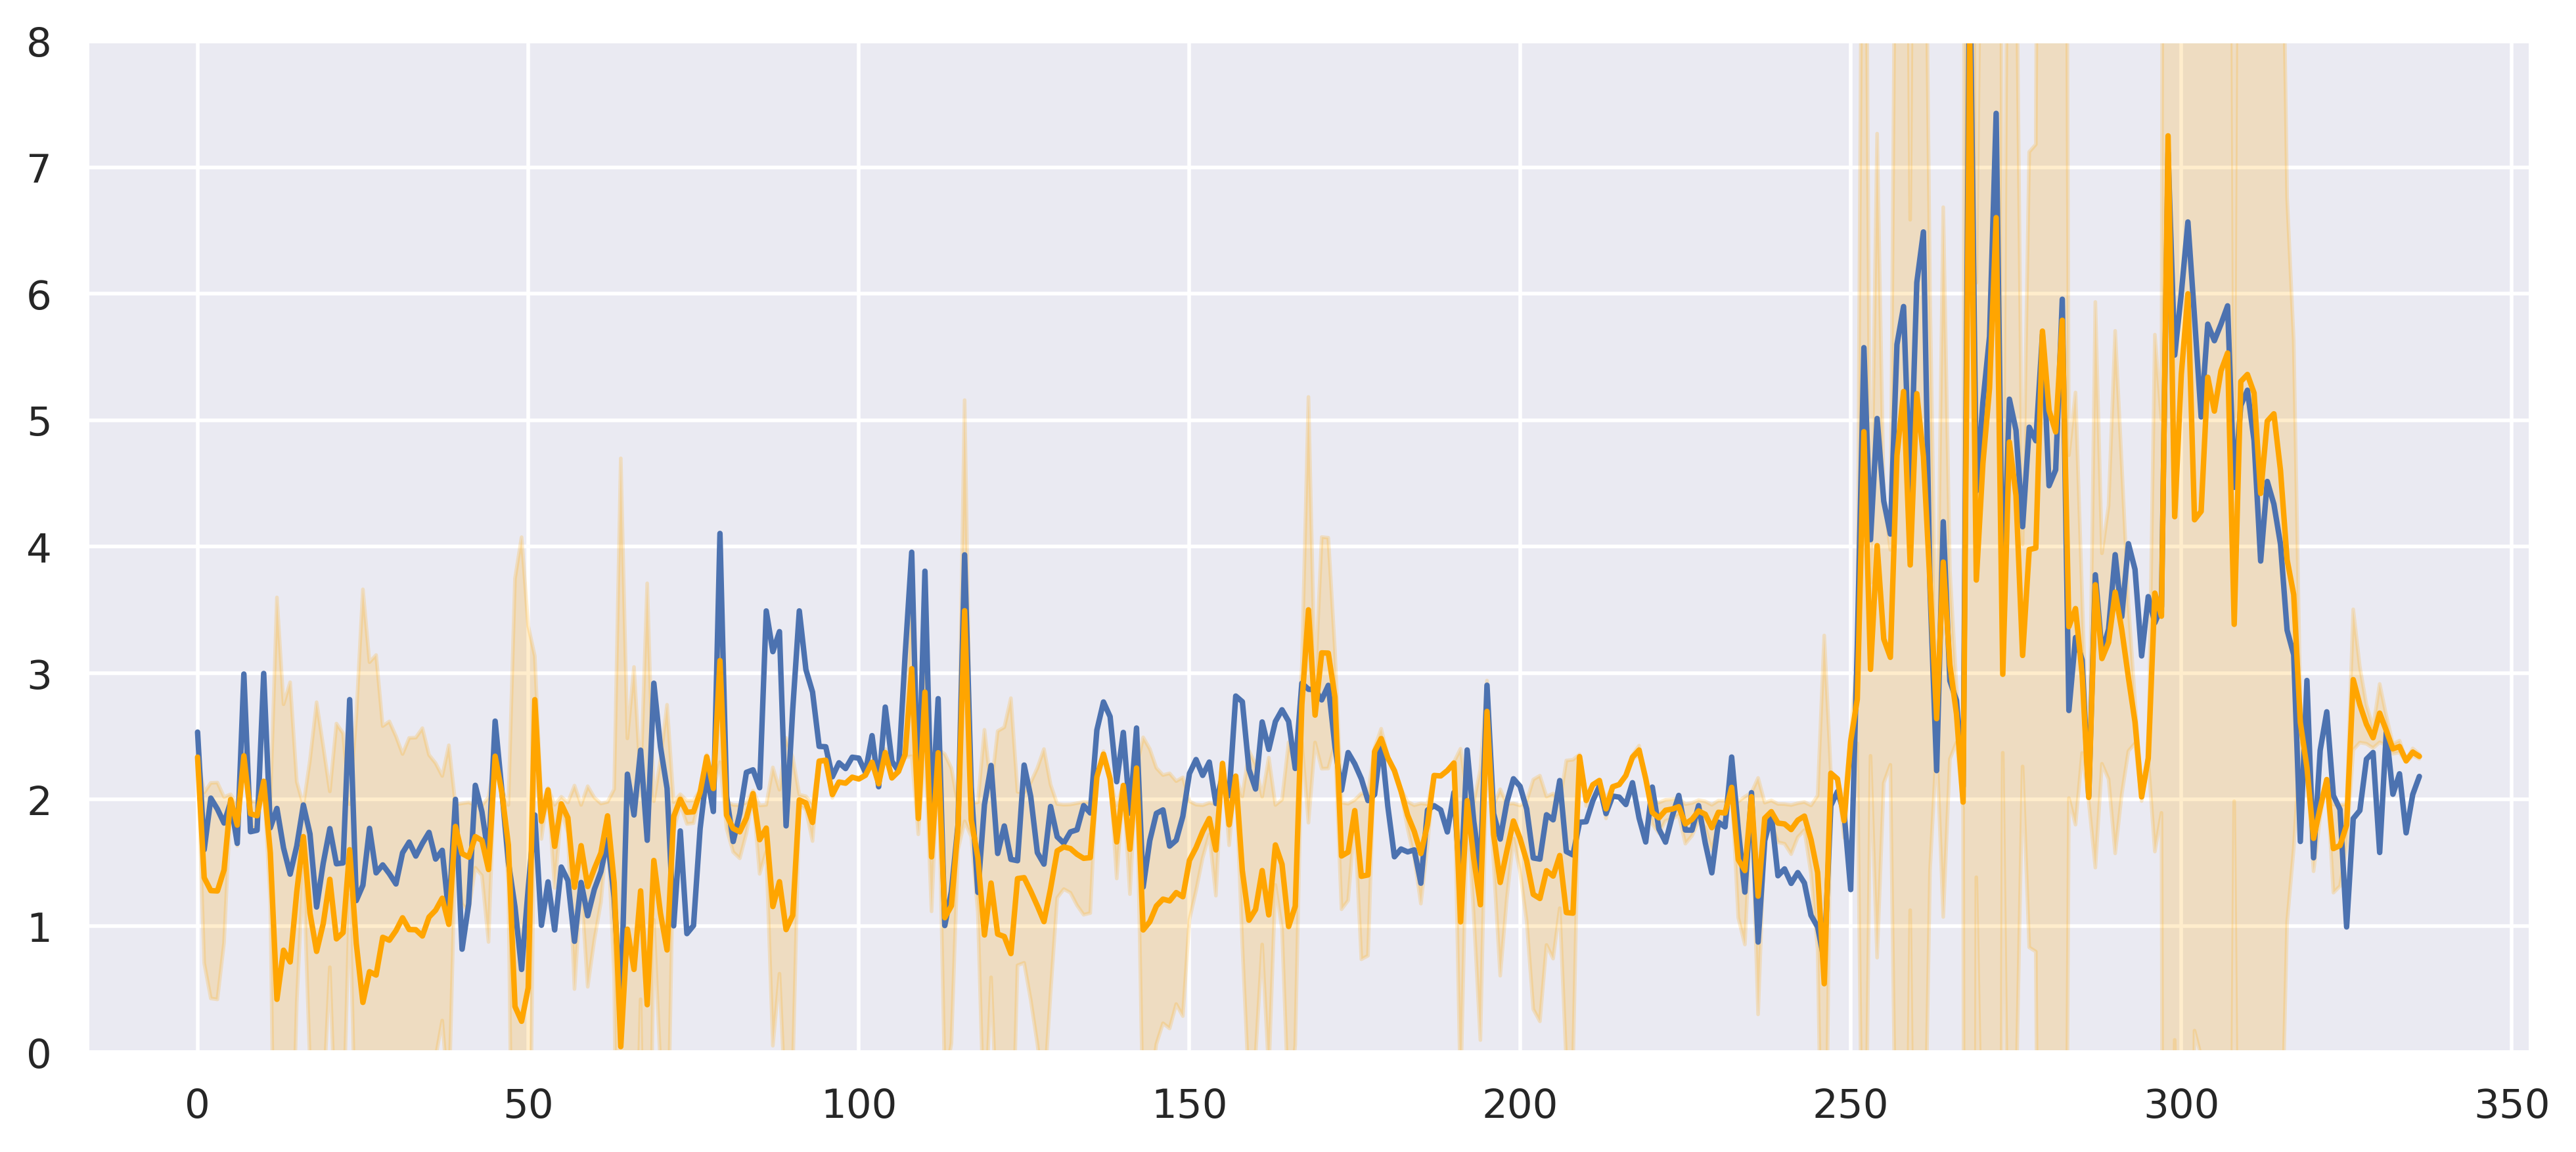

In [49]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
mu = np.mean(preds_vis)
error = np.square(preds_vis - mu)
ax.plot(gt_vis)
ax.plot(preds_vis, color="orange")
ax.fill_between(np.arange(preds_vis.shape[0]), preds_vis - error, preds_vis + error, alpha=0.2, color="orange")

ax.set_ylim(0, 8)

In [102]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rfr.fit(X_train, NEE_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [103]:
preds_rfr = rfr.predict(X_test)
gt_rfr = NEE_test.values

In [104]:
mean_absolute_error(gt_rfr, preds_rfr), r2_score(gt_rfr, preds_rfr)


(1.211197282177342, 0.6342242252390279)

In [105]:
gt_rfr_vis = gt_rfr[mask]
preds_rfr_vis = preds_rfr[mask]

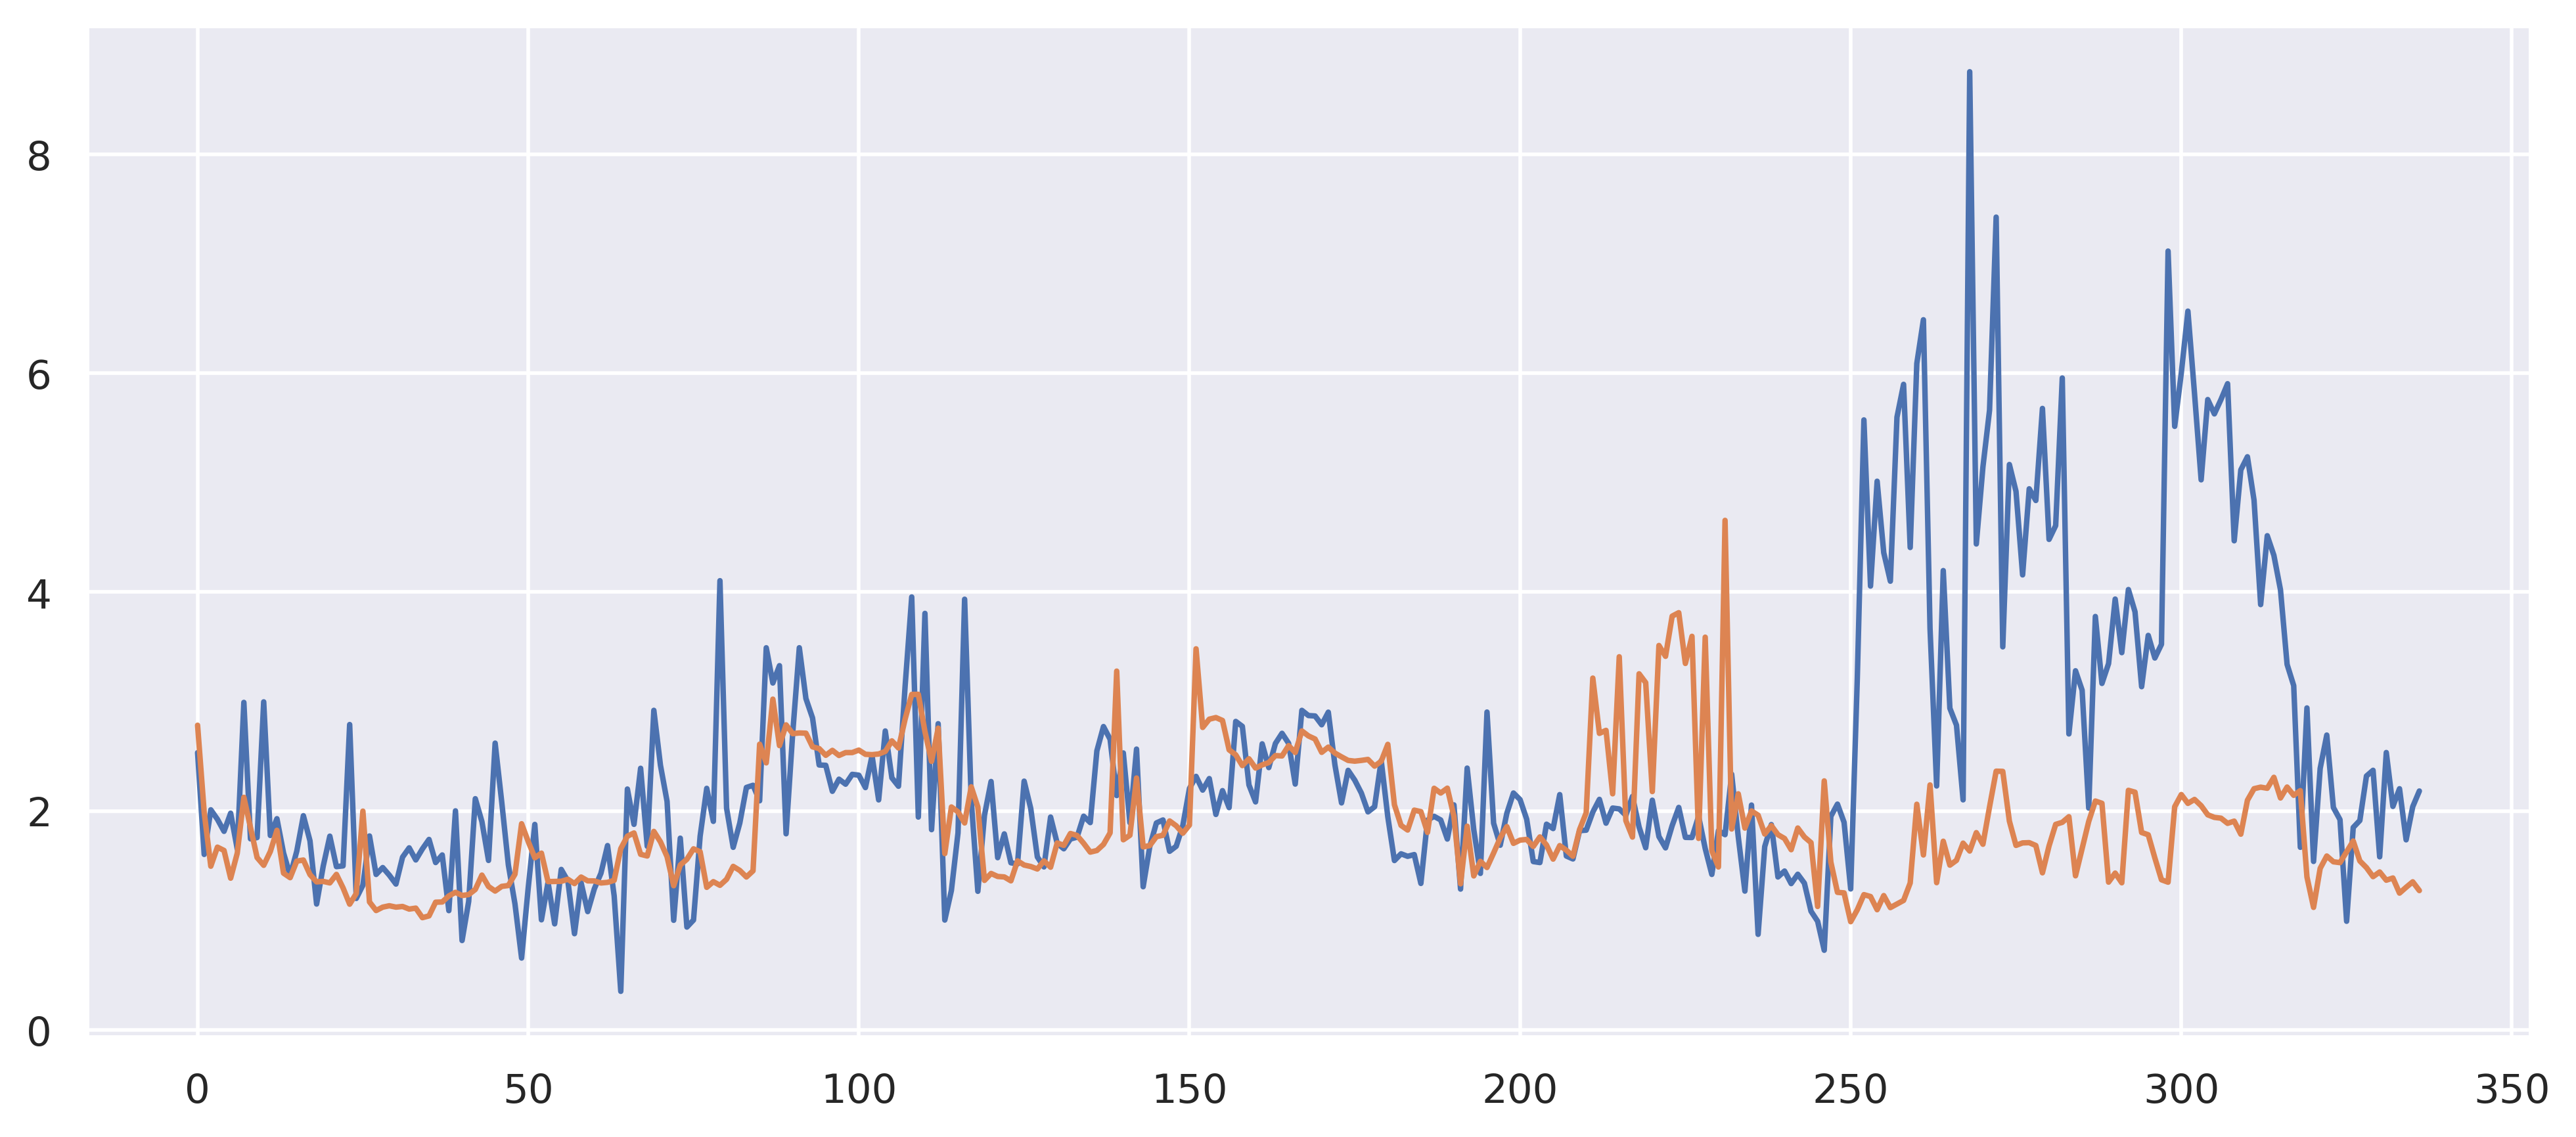

In [106]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
plt.plot(gt_rfr_vis)
plt.plot(preds_rfr_vis)

<BarContainer object of 15 artists>

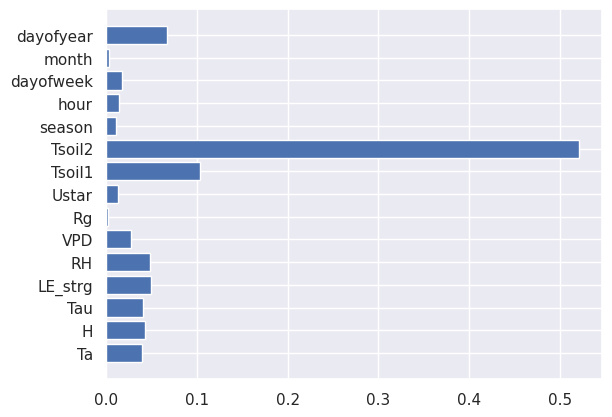

In [107]:
columns = drivers

plt.barh(columns, rfr.feature_importances_)

In [146]:
input_rfr = np.concatenate((X_train, bNEE_train.values.reshape((-1, 1))), axis=1)

In [147]:
rfr = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rfr.fit(input_rfr, NEE_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [148]:
input_rfr = np.concatenate((X_test, bNEE_test.values.reshape((-1, 1))), axis=1)

In [149]:
preds_rfr = rfr.predict(input_rfr)
gt_rfr = NEE_test.values

In [150]:
mean_absolute_error(gt_rfr, preds_rfr), r2_score(gt_rfr, preds_rfr)


(0.892917746627629, 0.7234063644970592)

In [151]:
gt_rfr_vis = gt_rfr[mask]
preds_rfr_vis = preds_rfr[mask]

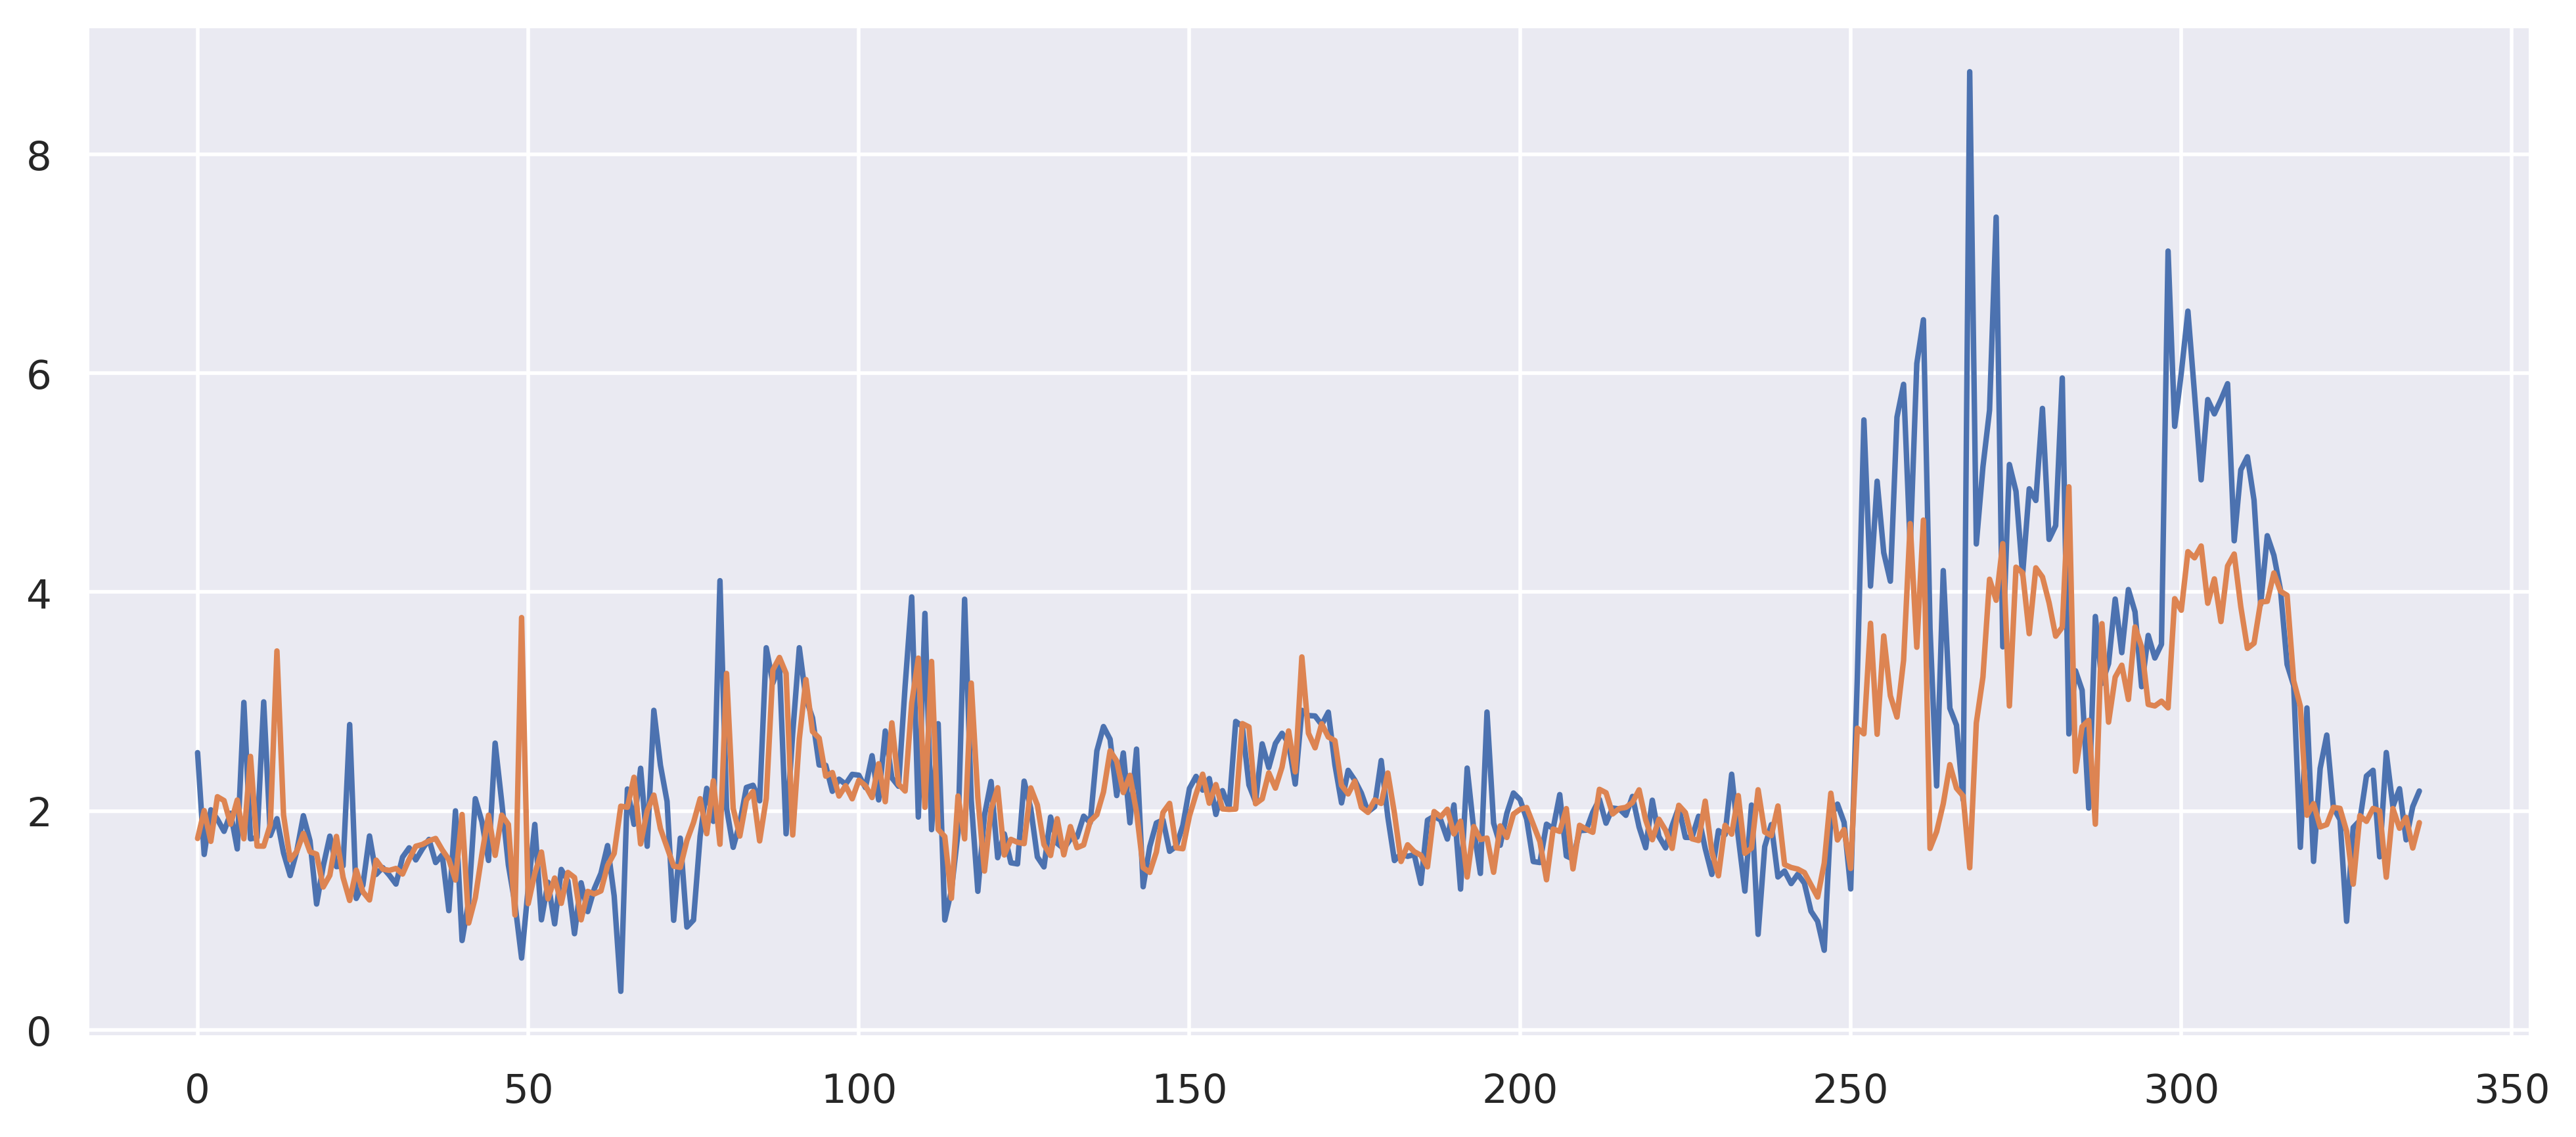

In [152]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
plt.plot(gt_rfr_vis)
plt.plot(preds_rfr_vis)

(0.0, 8.0)

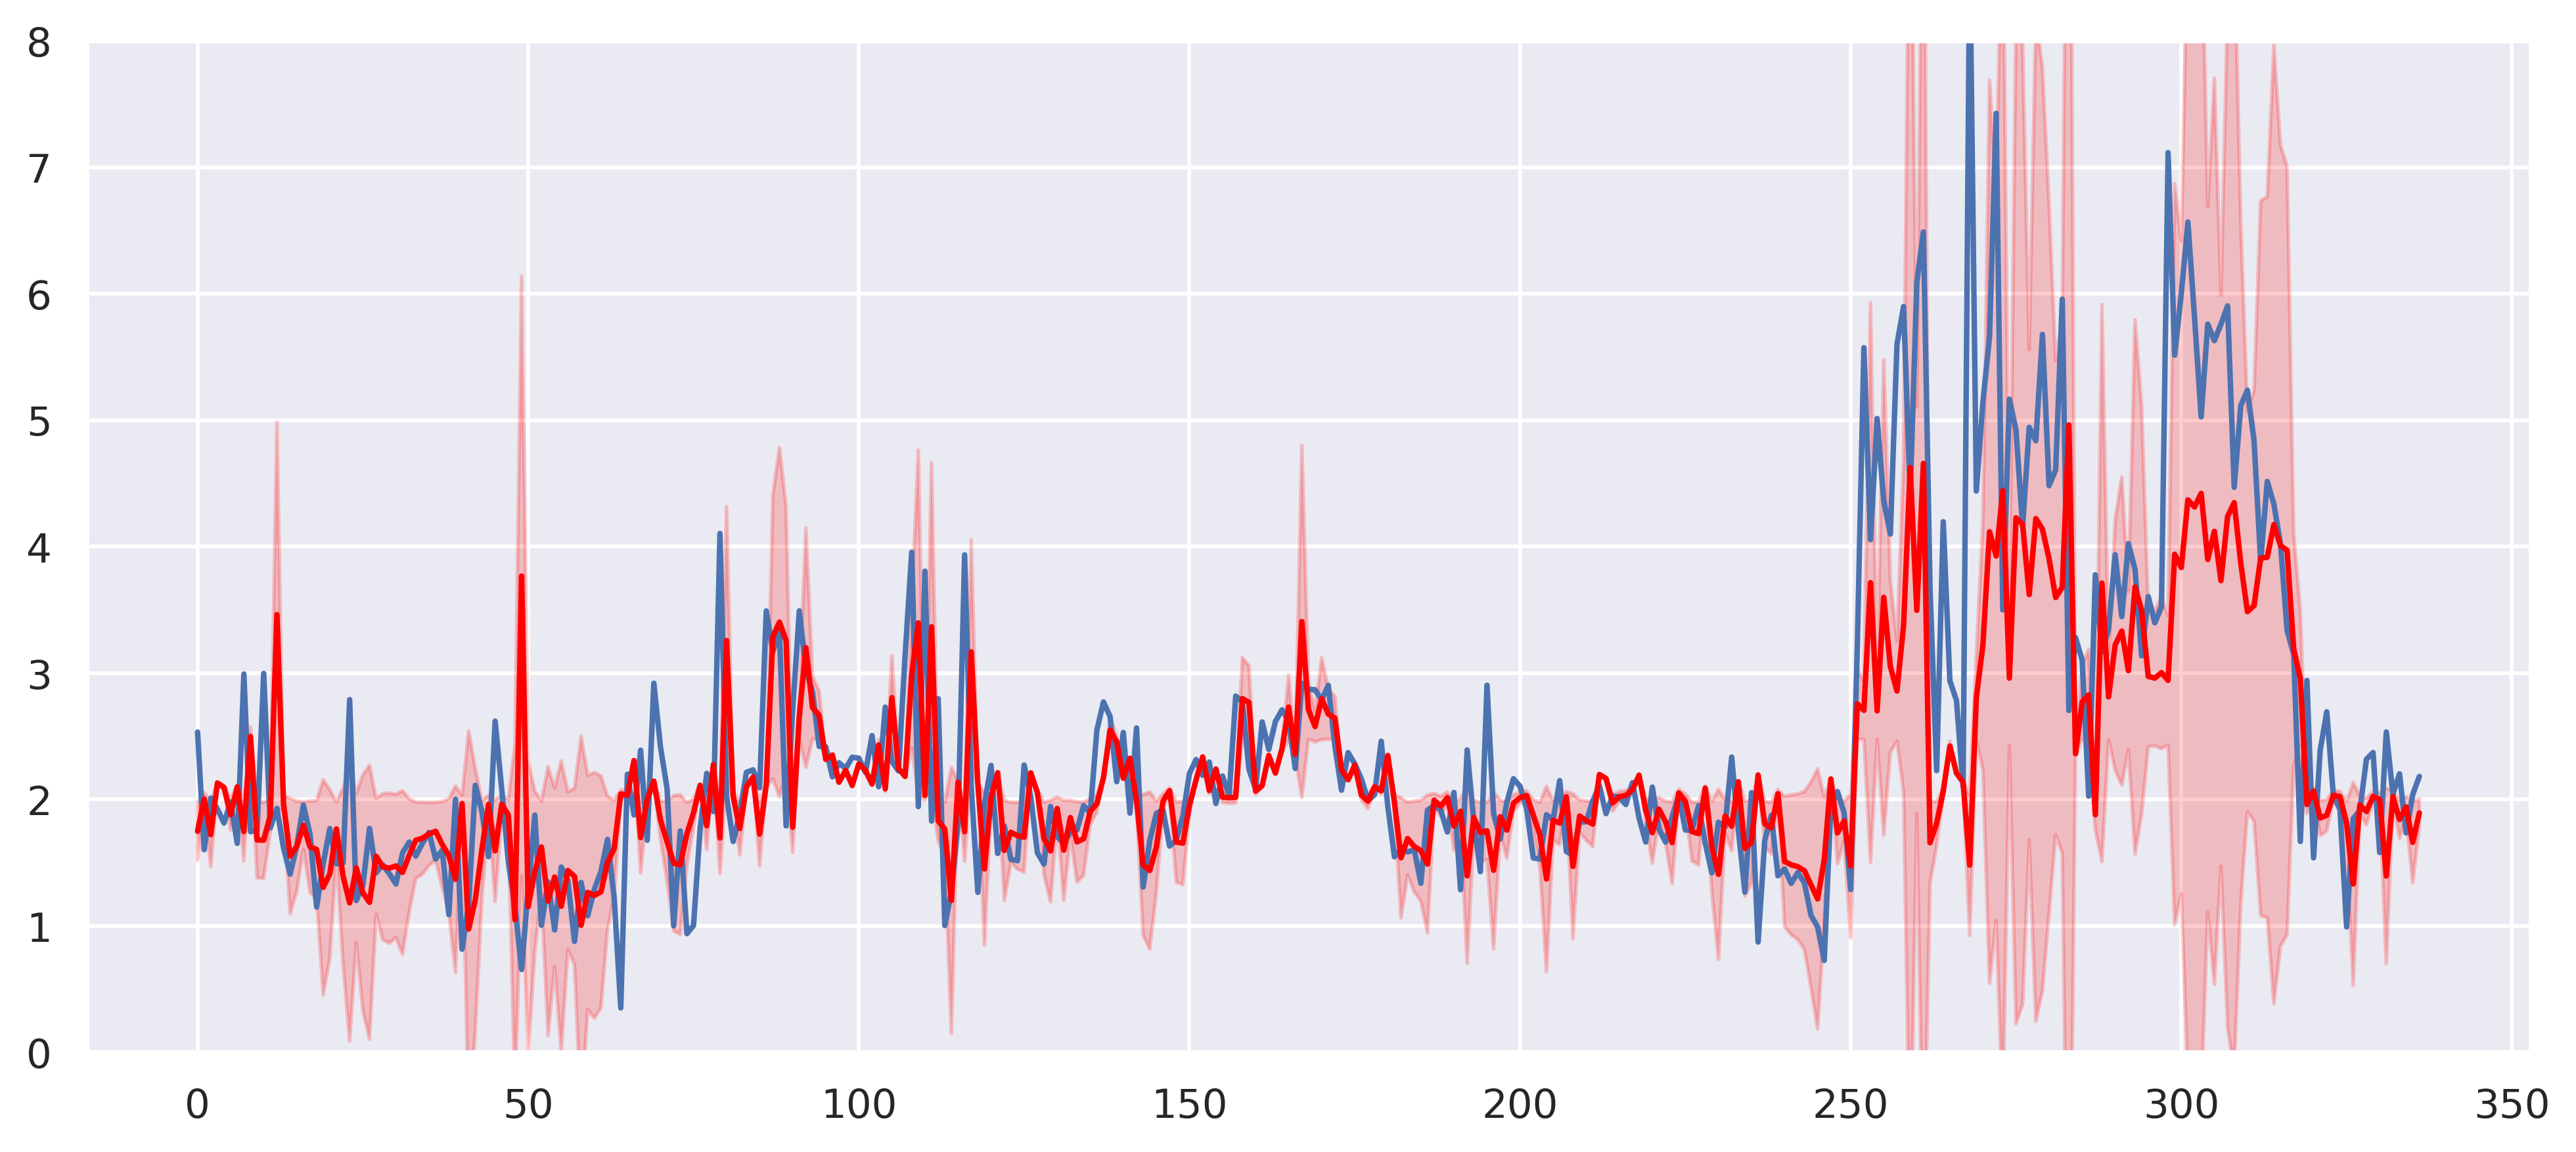

In [154]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
mu = np.mean(preds_rfr_vis)
error = np.square(preds_rfr_vis - mu)
ax.plot(gt_rfr_vis)
ax.plot(preds_rfr_vis, color="red")
ax.fill_between(np.arange(preds_rfr_vis.shape[0]), preds_rfr_vis - error, preds_rfr_vis + error, alpha=0.2, color="red")

ax.set_ylim(0, 8)